# iLykei Lecture Series

# Advanced Machine Learning and Artificial Intelligence

# Project: Satellite Imagery Feature Detection

## Creation of patches and predictions with augmentation

### Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc


## Augmentation during Training


Recall that the convolutional neural networks take image patches as input. Then sample for training CNN is set of all selected patches.
In order to increase training dataset, it is common to use a type of augmentation introduced  in this notebook.

First, read one image and plot it.

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f90b330b978>)

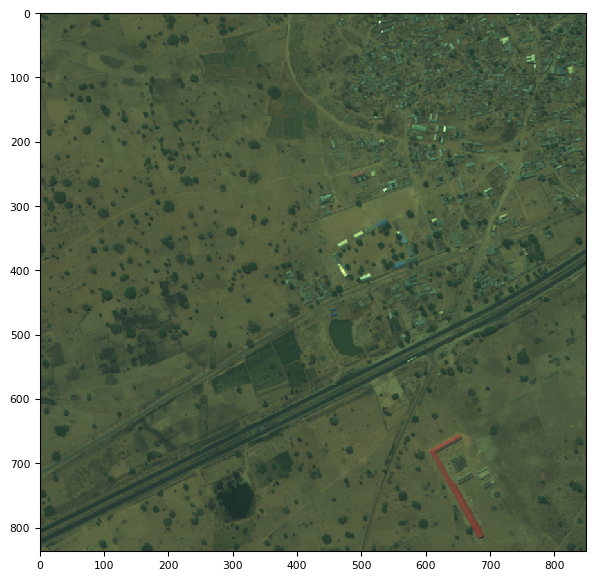

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import tifffile as tiff

id = '22'
img = tiff.imread('data/mband/{}.tif'.format(id)).transpose([1, 2, 0]) # make channels last
mask = tiff.imread('data/gt_mband/{}.tif'.format(id)) / 255
mask = mask.transpose([1, 2, 0])  # make channels last
tiff.imshow(img[:, :, (4,2,1)])  # select RGB channels

Chose random patch (both for image and mask):

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f908e10f630>)

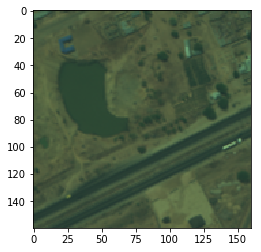

In [2]:
import random
sz = 160  # patch size

xc = random.randint(0, img.shape[0] - sz)
yc = random.randint(0, img.shape[1] - sz)
patch_img = img[xc:(xc + sz), yc:(yc + sz)]
patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]

tiff.imshow(patch_img[:, :, (4,2,1)],   # select RGB channels
            figure=plt.figure(figsize=(4,4)))

It might be useful to rotate the image before cropping a random square. This approach leads to some technical difficulties (mostly related to processing image borders). Instead use a simpler approach: select random patch from the original image and apply any subset of following three transformations:

- reverse $x$ coordinates
- reverse $y$ coordinates
- swap $x$ and $y$ coordinates

As a result, there are 8 possible patch transformations. Following function constructs them.

In [3]:
def rotate_img(img, r):
    # channels in img are last!!!
    # r is a transformation type (an integer from 0 to 7)
    reverse_x = r % 2 == 1         # True for r in [1,3,5,7]
    reverse_y = (r // 2) % 2 == 1  # True for r in [2,3,6,7]
    swap_xy = (r // 4) % 2 == 1    # True for r in [4,5,6,7]
    if reverse_x:
        img = img[::-1, :, :]
    if reverse_y:
        img = img[:, ::-1, :]
    if swap_xy:
        img = img.transpose([1, 0, 2])
    return img

Note that applying the same transformation twice leads us to original image. This will be used later in the second part of the notebook (see function `predict`).

Use combinations of these transformations to make 8 images out of the selected patch:

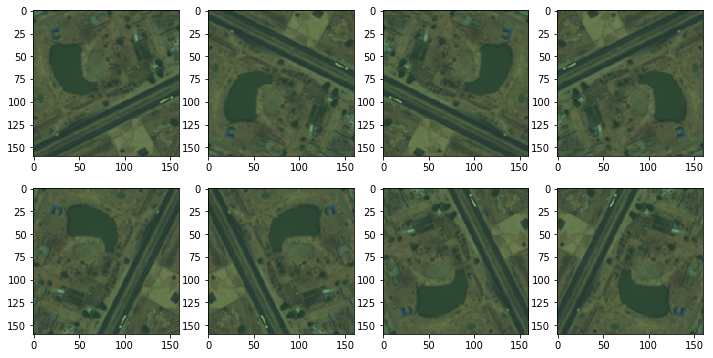

In [4]:
figure = plt.figure(figsize=(12,6))
for r in range(8):
    transformed_patch = rotate_img(patch_img, r)
    tiff.imshow(transformed_patch[:, :, (4,2,1)],   # select RGB channels
                figure=figure, subplot=240+r+1) 

**Do not forget to apply the same transformation to corresponding mask and store both transformed patch and mask together!**

Now create function making random patch from random image and the corresponding mask

In [5]:
def get_rand_patch(img, mask, sz=160, augment=True):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random crop
    :return: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]
    if augment:
        j = random.randint(0, 7)
        patch_img = rotate_img(patch_img, j)
        patch_mask = rotate_img(patch_mask, j)
    return patch_img, patch_mask

In [7]:
import random
random.randint(0, 7)

4

Create function making random collection of patches:

`def get_patches(x_dict, y_dict, n_crops, sz=160, augment=True):`,
where `x_dict` and `y_dict` are dictionaries of images and their corresponding masks; `n_crops` is number of images (masks) in the sample; `sz` is patch size. 

In this finction:

- make empty list of images `x` and empty list of the corresponding masks `y`
- while number of pairs of image and mask patches is less than `n_crops`:
    1. Select random image and corresponding mask from `x_dict` and `y_dict`
    2. Extract random patch from the image and mask using `get_rand_patch()`
    3. Append random patches to `x` and `y`

## Augmentation during Prediction

After neural network is trained, we need to make predictions for the original test images.

To do this crop test images into patches, make predictions using CNN and merge predictions back into one image.
However, this straightforward approach leads to bad results. 

Firstl, CNN usually gives worse performance near edges of patches (explain why). It is better to crop test image into overlapping patches, so that almost every part of the original image lies in center of some patch. Then use predictions for that central region of the patch.

Second, it is possible to use the same augmentation technique as for the training step: make 8 transformations of each test patch, make predictions for all transformations and average 8 predictions for every patch.

Create function `predict()`:

`def predict(img, model, patch_sz=160, border_sz=20, n_classes=5, augment=True):`
    
where border is a place around center in the patch where predictions are usually bad in U-Nets

In this function:

    1. Make extended image, so that it contains integer number of crossed-by-border patches; fill extended image with mirrors
    2. Assemble all patches in one array, append them to to one list
    3. Make predictions using augmentation if necessary

In [6]:
import math
import numpy as np


def predict(img, model, patch_sz=160, border_sz=20, n_classes=5, augment=True):
    ## model is a trained CNN    
    # border is a place around center in the patch where predictions are usually bad in u-nets
    img_height = img.shape[0]
    img_width = img.shape[1]
    n_channels = img.shape[2]

    # make extended img so that it contains integer number of crossed-by-border patches
    center_sz = patch_sz - 2 * border_sz
    npatches_vert = int(math.ceil((img_height - 2*border_sz)/center_sz))
    npatches_horizon = int(math.ceil((img_width - 2*border_sz)/center_sz))
    extended_height = 2*border_sz + center_sz * npatches_vert
    extended_width = 2*border_sz + center_sz * npatches_horizon
    ext_img = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirrors:
    ext_img[:img_height, :img_width, :] = img
    for i in range(img_height, extended_height):
        ext_img[i, :, :] = ext_img[2*img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_img[:, j, :] = ext_img[:, 2*img_width - j - 1, :]

    # now assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vert):
        for j in range(0, npatches_horizon):
            x0, x1 = i * center_sz, (i + 1) * center_sz + 2 * border_sz
            y0, y1 = j * center_sz, (j + 1) * center_sz + 2 * border_sz
            if augment:
                for r in range(8):
                    patches_list.append(rotate_img(ext_img[x0:x1, y0:y1, :], r))
            else:
                patches_list.append(ext_img[x0:x1, y0:y1, :])
    patches_arr = np.asarray(patches_list) # np.transpose(patches_list, (0, 1, 2, 3))
    # predictions:
    patches_predict = model.predict(patches_arr, batch_size=4)
    confidence_map_patch = np.full(shape=(patch_sz, patch_sz, n_classes), fill_value=0.1)  # low confidence for borders
    confidence_map_patch[border_sz:border_sz+center_sz, border_sz:border_sz+center_sz, :] = 1 # high confidence for center
    confidence_map_img = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    prd = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(0, patches_predict.shape[0]):  # for all predicted patches
        if augment:
            r = k % 8   # patch transformation type (0..7)
            i = k // 8 // npatches_horizon  # patch x-coordinate
            j = k // 8 % npatches_horizon   # patch y-coordinate
            x0, x1 = i * center_sz, (i + 1) * center_sz + 2 * border_sz
            y0, y1 = j * center_sz, (j + 1) * center_sz + 2 * border_sz
            confidence_map_img[x0:x1, y0:y1, :] += confidence_map_patch
            prd[x0:x1, y0:y1, :] += rotate_img(patches_predict[k, :, :, :], r) * confidence_map_patch
        else:
            i = k // npatches_horizon
            j = k % npatches_horizon
            x0, x1 = i * center_sz, (i + 1) * center_sz + 2 * border_sz
            y0, y1 = j * center_sz, (j + 1) * center_sz + 2 * border_sz
            confidence_map_img[x0:x1, y0:y1, :] += confidence_map_patch
            prd[x0:x1, y0:y1, :] += patches_predict[k, :, :, :] * confidence_map_patch
    prd /= confidence_map_img
    return prd[:img_height, :img_width, :]